# Intro to Developmental Interpretability

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/introduction.ipynb)

Developmental interpretability ("devinterp") studies how structure develops over the course of training. 

## Aim

Our aim is to develop tools for detecting, understanding, and preventing dangerous transitions during training — to capabilities, values, behaviors. 

This library is where we'll put those tools. **It's very much a work in progress** (and we welcome contributions).

## Set-up

In [1]:
%pip install devinterp transformers torchvision

Note: you may need to restart the kernel to use updated packages.


# Methods

## Local Learning Coefficients

The first method we have have online is local learning coefficient estimation ([Lau et al. 2023](https://arxiv.org/abs/2308.12108)). 

For an in-depth explaination, see [this post](https://www.lesswrong.com/posts/6g8cAftfQufLmFDYT/you-re-counting-your-parameters-wrong). The short version is that: 
- The (local) learning coefficient $\hat\lambda$ is the "correct" measure of model complexity. Besides the loss, it's the most principled high-level way to compare models.
- We can cheaply estimate the learning coefficient associated to a choice of weights $\hat w^*$ by using the following formula:

$$
\hat\lambda(\hat w^*)=\frac{\mathbb{E}_{w|\hat w^*, \gamma}^{\beta^*}\left[n L_n(w)\right] - n L_n(\hat w^*)}{\log n}.
$$

where, $n$ is the number of (training) samples, $L_n(w)$ is the negative log likelihood (i.e., your objective function), and $\mathbb{E}_w^{\beta^*}\left[n L_n(w)\right]$ is a "local average" of $nL_n(w)$ over a neighborhood of $\hat w^*$. The parameters $\gamma$ and $\beta^*$ control the local averaging.

The difficulty is in performing the local average: we need to sample enough points and they need to be both diverse / spread out enough and close enough to the starting weight. To make sure they're spread out enough we use an optimizer like Stochastic Gradient Langevin Dynamics (SGLD), which is SGD plus Gaussian noise.


In [2]:
import yaml

import torch
import torchvision
from transformers import AutoModelForImageClassification
from torch.nn import functional as F

from devinterp.slt import estimate_learning_coeff_with_summary
from devinterp.optim import SGLD
from devinterp.utils import plot_trace

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

/home/paperspace/devinterp/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load a pretrained MNIST classifier
model = AutoModelForImageClassification.from_pretrained("fxmarty/resnet-tiny-mnist")
data = torchvision.datasets.MNIST(
    root="../data",
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
        ]
    ),
)
loader = torch.utils.data.DataLoader(data, batch_size=256, shuffle=True)


def criterion(inputs, outputs):
    return F.cross_entropy(inputs.logits, outputs)  # transformers doesn't output a vector


learning_coeff_stats = estimate_learning_coeff_with_summary(
    model,
    loader=loader,
    criterion=criterion,
    sampling_method=SGLD,
    optimizer_kwargs=dict(lr=3e-5, elasticity=1., num_samples=len(data)),
    num_chains=3,  # How many independent chains to run
    num_draws=200,  # How many samples to draw per chain
    num_burnin_steps=0,  # How many samples to discard at the beginning of each chain
    num_steps_bw_draws=1,  # How many steps to take between each sample
    device=DEVICE,
)
trace = learning_coeff_stats.pop("loss/trace")

print("Lambda hat estimates:")
print(yaml.dump(learning_coeff_stats))

/home/paperspace/devinterp/.venv/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Chain 2: 100%|██████████| 200/200 [00:10<00:00, 18.29it/s]

Lambda hat estimates:
llc-chain/0: 653.4756469726562
llc-chain/1: 611.9108276367188
llc-chain/2: 648.7933349609375
llc/mean: 638.0599975585938
llc/std: 22.766504287719727



### Diagnostics

Below you'll see what's actually happening when you run `local_learning_coefficients`.

We sample 10 different chains, with the same starting positions but different batch schedules and noise realizations at each step. For each of these chains, we take 100 steps using SGLD. We observe the loss at each of these points. At the end, we average the loss across chains, compare it to the initial loss, and apply a correction that depends on the dataset size to get the local learning coefficient. 

For a healthy chain, the loss should increase rapidly at first and then level off.

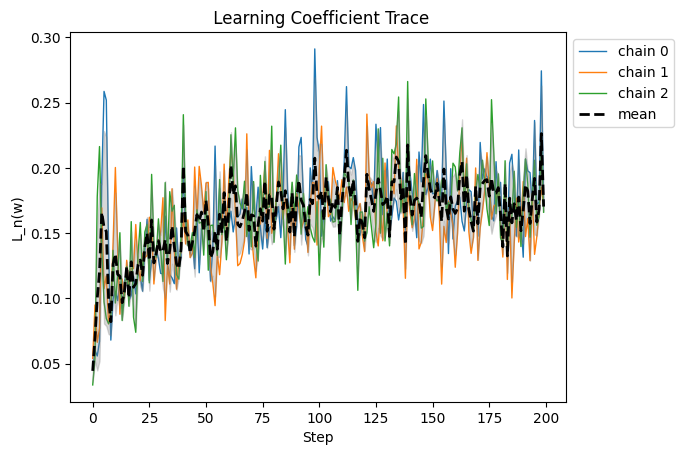

<Figure size 1200x900 with 0 Axes>

In [4]:
plot_trace(trace, 'L_n(w)', x_axis='Step', title=' Learning Coefficient Trace', plot_mean=False, plot_std=False, fig_size=(12, 9), true_lc = None)

To get a better understanding of the sampling methods, check out [`normal_crossing.ipynb`](../examples/normal_crossing.ipynb) and [`mnist.ipynb`](../examples/mnist.ipynb) where we compare SGLD to a variant known as Stochastic Gradient Nose-Hoover Thermostat (SGNHT), respectively in a simple toy landscape and on MNIST. [`sgld_calibration.ipynb`](../examples/sgld_calibration.ipynb) shows how to gain confidence in using SGLD-based LLC estimation to a model with unknown LLC, and [`diagnostics.ipynb`](../examples/diagnostics.ipynb) shows how to use callbacks to diagnose if your sampling is going well.

## Project ideas

What can you do with this? We wrote up [a bunch of ideas](https://devinterp.com/projects), most of which are focused on learning coefficient estimation, and we'd recommend starting there. There's a lot of low-hanging fruit. 

## Other Techniques

There are plenty of other techniques that would fit naturally under the umbrella of "developmental interpretability." If you're interested in looking beyond learning coefficient estimation, here are some ideas (we welcome PRs to introduce these methods to the library!):

- **Dimensionality reduction techniques**: Run PCA / t-SNE / UMAP / etc. over the weights / [tokens](https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/index.html#per-token-loss-intro) / activations over time. For larger models, you'll have to restrict your attention to a subset of the weights and activations for this to be tractable
- **Progress measures**. If you have an understanding of some structure at the end of training, you can roll that understanding backwards to track how that structure develops over time. 
- **Probes**. Similarly, you can train a linear probe from activations onto features, then roll that probe back to previous checkpoints to measure how those features are learned. 
- **Gradients**. Just look at the gradients! 
- **Evals**. You can measure performance on a targeted benchmarks to track when the model learns the associated capabilities. 
- **Covariance estimators**. That's a secret for now. More coming soon!

# Systems

## Toy Landscapes

See [`normal_crossing.ipynb`](../examples/normal_crossing.ipynb) for a demo of how to use the library on a simple toy landscape.

## Toy Models of Superposition

See [`tms.ipynb`](../examples/tms.ipynb) for a demo of how to use the library on toy models of superposition.

## Deep Linear Networks

See [`dlns.ipynb`](../examples/dlns.ipynb) for a demo of how to use the library on deep linear networks.

## MNIST

See [`mnist.ipynb`](../examples/mnist.ipynb) for a demo of how to use the library on MNIST.

## ResNets

See [`resnets.ipynb`](../examples/resnets.ipynb) for a (basic) demo of how to use the library on ResNets.